# Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, r2_score, precision_score, recall_score, f1_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.transforms import Bbox
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import rcParams
rcParams['text.usetex'] = True
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

2023-03-13 09:24:15.435537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 09:24:15.658842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-13 09:24:15.658859: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-13 09:24:15.689777: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-13 09:24:16.291088: W tensorflow/stream_executor/platform/de

# Preprocesing data

## Reading data

In [3]:
n_bound = 1
data_k = pd.read_excel('kernel_shuffled.xlsx',header=None)
data_b = pd.read_excel('bound_shuffled.xlsx', sheet_name=f'Sheet{n_bound}', header=None)

In [4]:
y_data_k = data_k.get(data_k.shape[1]-1)
X_data_k = data_k.drop(columns=data_k.shape[1]-1)
y_data_b = data_b.get(data_b.shape[1]-1) 
X_data_b = data_b.drop(columns=data_b.shape[1]-1)

## Spliting data

In [5]:
# Kernel train test
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_data_k, y_data_k, test_size=0.2)
# Bound train test
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_data_b, y_data_b, test_size=0.2)

In [6]:
# Kernel + Bound train test
X_train_kb = pd.concat([X_train_k, X_train_b], axis=0)
y_train_kb = pd.concat([y_train_k, y_train_b], axis=0)
y_train_c = np.concatenate([np.zeros(y_train_k.shape), np.ones(y_train_b.shape)], axis=0).astype(int)
X_test_kb = pd.concat([X_test_k, X_test_b], axis=0)
y_test_kb = pd.concat([y_test_k, y_test_b], axis=0)
y_test_c = np.concatenate([np.zeros(y_test_k.shape), np.ones(y_test_b.shape)], axis=0).astype(int)

## Preparing data for classification

In [7]:
X_train = X_train_kb.assign(c=y_train_c, y=y_train_kb)
X_train = X_train.sample(frac=1).reset_index(drop=True)
y_train_class = X_train.get('c')
y_train_kb = X_train.get('y')
X_train_kb = X_train.drop(columns=['y','c'])

In [8]:
X_test = X_test_kb.assign(c=y_test_c, y=y_test_kb)
X_test = X_test.sample(frac=1,axis=0).reset_index(drop=True)
y_test_kb = X_test.get('y')
X_test = X_test.drop(columns='y')
y_test_class = X_test.get('c')
X_test_kb = X_test.drop(columns='c')

In [9]:
std_class = StandardScaler()
X_train_kb_std = std_class.fit_transform(X_train_kb, y_train_class)
X_test_kb_std = std_class.transform(X_test_kb)

(array([800.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 800.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

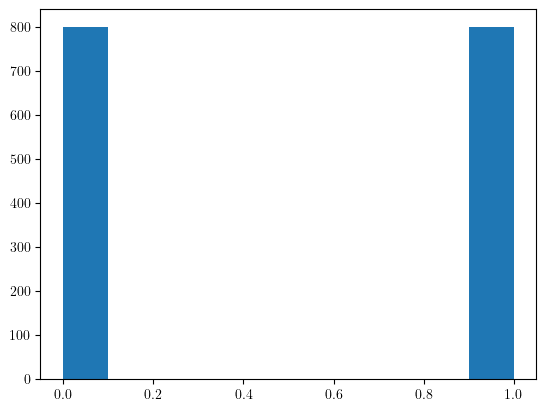

In [10]:
plt.hist(y_train_class)

## Preparing data for regression

In [11]:
std = StandardScaler()
# Kernel --> 
X_train_k_std = std.fit_transform(X_train_k, y_train_k)
# --> Kernel
X_test_k_k_std = std.transform(X_test_k)
# --> Bound
X_test_k_b_std = std.transform(X_test_b)

In [12]:
std2 = StandardScaler()
# Bound --> 
X_train_b_std = std2.fit_transform(X_train_b, y_train_b)
# --> Bound
X_test_b_b_std = std2.transform(X_test_b)
# --> Kernel
X_test_b_k_std = std2.transform(X_test_k)

In [13]:
std3 = StandardScaler()
# Kernel + Bound -->
X_train_kb_std = std3.fit_transform(X_train_kb, y_train_kb)
# --> Kernel
X_test_kb_k_std = std3.transform(X_test_k)
# --> Bound
X_test_kb_b_std = std3.transform(X_test_b)

In [14]:
y_test_b

508    0.000610
159    0.000535
331    0.000547
358    0.000519
137    0.000539
         ...   
985    0.000566
381    0.000521
981    0.000535
850    0.000613
135    0.000624
Name: 6, Length: 200, dtype: float64

# ML Classification models

Logistic Regression Report
               precision    recall  f1-score   support

           0       0.96      0.87      0.91       200
           1       0.88      0.96      0.92       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400

0.9213022528318071
0.9175
0.9173134384454926
SVM Report
               precision    recall  f1-score   support

           0       0.97      0.83      0.90       200
           1       0.86      0.97      0.91       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.90       400
weighted avg       0.91      0.91      0.90       400

0.9130966952264381
0.905
0.9045322078183097

 Decision Tree 
 	 mean precision 	 mean recall 	 	 mean fscore 

0.0 	 0.9291 	 	 0.917 	 	 0.923 

1.0 	 0.9181 	 	 0.93 	 	 0.924 

	 std precision 	 	 std recall 	 	 std fscore 

0.0 	 0.0085 	 	 0.004 	 	 0.005 

<Figure size 640x480 with 0 Axes>

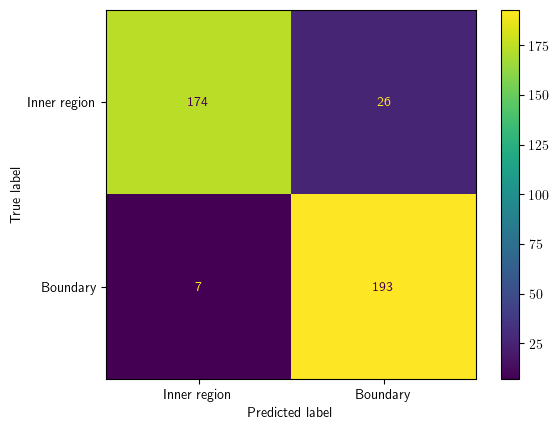

<Figure size 640x480 with 0 Axes>

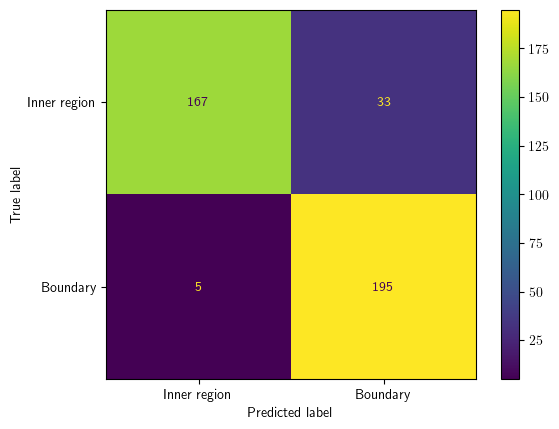

<Figure size 640x480 with 0 Axes>

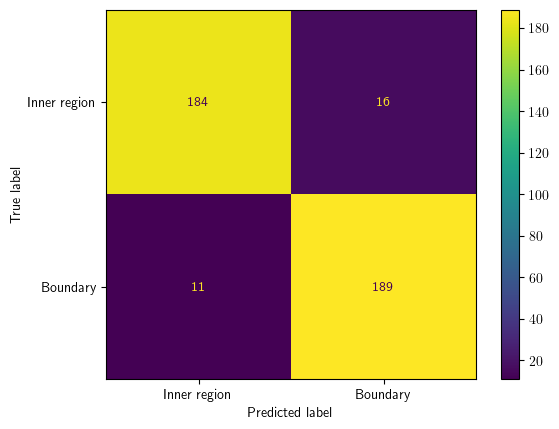

<Figure size 640x480 with 0 Axes>

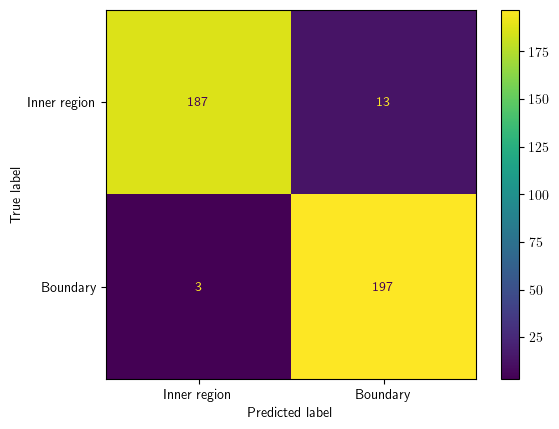

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

#LR
lr = LogisticRegression()
lr.fit(X_train_kb_std, y_train_class)
y_predict_lr = lr.predict(X_test_kb_std)
print('Logistic Regression Report\n', classification_report(y_test_class, y_predict_lr))
print(precision_score(y_test_class, y_predict_lr, average='weighted'))
print(recall_score(y_test_class, y_predict_lr, average='weighted'))
print(f1_score(y_test_class, y_predict_lr, average='weighted'))

#SVC
svc = SVC()
svc.fit(X_train_kb_std, y_train_class)
y_predict_svc = svc.predict(X_test_kb_std)
print('SVM Report\n', classification_report(y_test_class, y_predict_svc))
print(precision_score(y_test_class, y_predict_svc, average='weighted'))
print(recall_score(y_test_class, y_predict_svc, average='weighted'))
print(f1_score(y_test_class, y_predict_svc, average='weighted'))

#DT
precision_dt = []
recall_dt = []
fscore_dt = []
support_dt = []
precision_score_dt = []
recall_score_dt = []
f1_score_dt = []
for r in range(5):
    dt = DecisionTreeClassifier()
    dt.fit(X_train_kb_std, y_train_class)
    y_predict_dt = dt.predict(X_test_kb_std)
    precision,recall,fscore,support=score(y_test_class, y_predict_dt, average=None)
    precision_dt.append(precision)
    recall_dt.append(recall)
    fscore_dt.append(fscore)
    support_dt.append(support)

    p_s = precision_score(y_test_class, y_predict_dt, average='weighted')
    r_s = recall_score(y_test_class, y_predict_dt, average='weighted')
    f_s = f1_score(y_test_class, y_predict_dt, average='weighted')

    precision_score_dt.append(p_s)
    recall_score_dt.append(r_s)
    f1_score_dt.append(f_s)

precision_dt = np.array(precision_dt)
mean_precision_dt = np.mean(precision_dt, axis=0)
std_precision_dt = np.std(precision_dt, axis=0)

recall_dt = np.array(recall_dt)
mean_recall_dt = np.mean(recall_dt, axis=0)
std_recall_dt = np.std(recall_dt, axis=0)

fscore_dt = np.array(fscore_dt)
mean_fscore_dt = np.mean(fscore_dt, axis=0)
std_fscore_dt = np.std(fscore_dt, axis=0)

support_dt = np.array(support_dt)
mean_support_dt = np.mean(support_dt, axis=0)
std_support_dt = np.std(support_dt, axis=0)

print('\n','Decision Tree', '\n', '\t', 'mean precision', '\t', 'mean recall', '\t \t', 'mean fscore','\n')
print('0.0', '\t', round(mean_precision_dt[0], 4), '\t \t', round(mean_recall_dt[0], 4), '\t \t', round(mean_fscore_dt[0], 4), '\n')
print('1.0', '\t', round(mean_precision_dt[1], 4), '\t \t', round(mean_recall_dt[1], 4), '\t \t', round(mean_fscore_dt[1], 4), '\n')
print('\t', 'std precision', '\t \t', 'std recall', '\t \t', 'std fscore','\n')
print('0.0','\t', round(std_precision_dt[0], 4), '\t \t', round(std_recall_dt[0], 4), '\t \t', round(std_fscore_dt[0], 4), '\n')
print('1.0','\t', round(std_precision_dt[1], 4), '\t \t', round(std_recall_dt[1], 4), '\t \t', round(std_fscore_dt[1], 4), '\n')

print(np.mean(precision_score_dt))
print(np.mean(recall_score_dt))
print(np.mean(f1_score_dt))
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

#RF
precision_rf = []
recall_rf = []
fscore_rf = []
support_rf = []
precision_score_rf = []
recall_score_rf = []
f1_score_rf = []
for r in range(5):
    rf = RandomForestClassifier()
    rf.fit(X_train_kb_std, y_train_class)
    y_predict_rf = rf.predict(X_test_kb_std)
    precision,recall,fscore,support=score(y_test_class, y_predict_dt, average=None)
    precision_rf.append(precision)
    recall_rf.append(recall)
    fscore_rf.append(fscore)
    support_rf.append(support)

    p_s = precision_score(y_test_class, y_predict_rf, average='weighted')
    r_s = recall_score(y_test_class, y_predict_rf, average='weighted')
    f_s = f1_score(y_test_class, y_predict_rf, average='weighted')

    precision_score_rf.append(p_s)
    recall_score_rf.append(r_s)
    f1_score_rf.append(f_s)

precision_rf = np.array(precision_rf)
mean_precision_rf = np.mean(precision_rf, axis=0)
std_precision_rf = np.std(precision_rf, axis=0)

recall_rf = np.array(recall_rf)
mean_recall_rf = np.mean(recall_rf, axis=0)
std_recall_rf= np.std(recall_rf, axis=0)

fscore_rf = np.array(fscore_rf)
mean_fscore_rf = np.mean(fscore_rf, axis=0)
std_fscore_rf = np.std(fscore_rf, axis=0)


support_rf = np.array(support_rf)
mean_support_rf = np.mean(support_rf, axis=0)
std_support_rf = np.std(support_rf, axis=0)

print('\n','Random Forest', '\n', '\t', 'mean precision', '\t', 'mean recall', '\t \t', 'mean fscore','\n')
print('0.0', '\t', round(mean_precision_rf[0], 4), '\t \t', round(mean_recall_rf[0], 4), '\t \t', round(mean_fscore_rf[0], 4), '\n')
print('1.0', '\t', round(mean_precision_rf[1], 4), '\t \t', round(mean_recall_rf[1], 4), '\t \t', round(mean_fscore_rf[1], 4), '\n')
print('\t', 'std precision', '\t \t', 'std recall', '\t \t', 'std fscore','\n')
print('0.0','\t', round(std_precision_rf[0], 4), '\t \t \t', round(std_recall_rf[0], 4), '\t \t \t', round(std_fscore_rf[0], 4), '\n')
print('1.0','\t', round(std_precision_rf[1], 4), '\t \t \t', round(std_recall_rf[1], 4), '\t \t \t', round(std_fscore_rf[1], 4), '\n')

print(np.mean(precision_score_rf))
print(np.mean(recall_score_rf))
print(np.mean(f1_score_rf))

fig1 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_lr,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/confusion_matrix_lr.eps')
plt.show()

fig2 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_svc,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/confusion_matrix_svc.eps')
plt.show()

fig3 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_dt,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/confusion_matrix_dt.eps')
plt.show()

fig4 = plt.figure()
metrics.ConfusionMatrixDisplay.from_predictions(y_test_class, y_predict_rf,display_labels=["Inner region", "Boundary"])
plt.savefig('./figures/confusion_matrix_rf.eps')
plt.show()

# Regression problem

## Testing the Kernel

### Kernel --> Kernel

In [16]:
#Kernel data
#Train data', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
#data_k_train = pd.read_excel('train_kernel_bound_forKernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#### Regression models

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

mlp = MLPRegressor(learning_rate='adaptive')
mlp.fit(X_train_k_std, y_train_k)
y_predict_mlp_k = mlp.predict(X_test_k_k_std)

#param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#          'activation': ['relu','tanh','logistic'],
#          'alpha': [0.0001, 0.05, 0.1],
#          'learning_rate': ['constant','adaptive'],
#          'solver': ['adam','sgd']}

#gsc = GridSearchCV(mlp,param_grid,cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

#grid_result = gsc.fit(X_train_k_std, y_train_k)

#print(grid_result.best_params_)

#y_predict_mlp_k = gsc.predict(X_test_k_k_std)


lr = LinearRegression()
lr.fit(X_train_k_std, y_train_k)
y_predict_lr_k = lr.predict(X_test_k_k_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_k_std, y_train_k)
y_predict_svr_k = svr.predict(X_test_k_k_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
rmse_dt = []
r2_dt = []
mape_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_k_std, y_train_k)
    y_predict_dt_k = dt.predict(X_test_k_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_dt_k)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_dt_k))
    r2 = r2_score(y_test_k, y_predict_dt_k)
    mape = mean_absolute_percentage_error(y_test_k, y_predict_dt_k)
    mae_dt.append(mae)
    rmse_dt.append(rmse)
    r2_dt.append(r2)
    mape_dt.append(mape)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

mae_rf = []
rmse_rf = []
r2_rf = []
mape_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_k_std, y_train_k)
    y_predict_rf_k = rf.predict(X_test_k_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_rf_k)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_rf_k))
    r2 = r2_score(y_test_k, y_predict_rf_k)
    mape = mean_absolute_percentage_error(y_test_k, y_predict_rf_k)
    mae_rf.append(mae)
    rmse_rf.append(rmse)
    r2_rf.append(r2)
    mape_rf.append(mape)
    # plt.plot(y_test_k)
    # plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_lr_k))
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_mlp_k))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_svr_k))
rmse_dt = np.mean(rmse_dt)
rmse_rf = np.mean(rmse_rf)
mae_lr = metrics.mean_absolute_error(y_test_k, y_predict_lr_k)
mae_mlp = metrics.mean_absolute_error(y_test_k, y_predict_mlp_k)
mae_svr = metrics.mean_absolute_error(y_test_k, y_predict_svr_k)
mae_dt = np.mean(mae_dt)
mae_rf = np.mean(mae_rf)
r2_lr = r2_score(y_test_k, y_predict_lr_k)
r2_mlp = r2_score(y_test_k, y_predict_mlp_k)
r2_svr = r2_score(y_test_k, y_predict_svr_k)
r2_dt = np.mean(r2_dt)
r2_rf = np.mean(r2_rf)
mape_lr = mean_absolute_percentage_error(y_test_k, y_predict_lr_k)
mape_mlp = mean_absolute_percentage_error(y_test_k, y_predict_mlp_k)
mape_svr = mean_absolute_percentage_error(y_test_k, y_predict_svr_k)
mape_dt = np.mean(mape_dt)
mape_rf = np.mean(mape_rf)

print('Root Mean Squared Error:''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error:''\n', 'LR: ''\t', mae_lr, '\n', 'MLP: ''\t', mae_mlp, '\n', 'SVR: ''\t', mae_svr, '\n', 'DT: ''\t', mae_dt, '\n', 'RF: ''\t', mae_rf, '\n', )
print('R2 Score:''\n', 'LR: ''\t', r2_lr, '\n', 'MLP: ''\t', r2_mlp, '\n', 'SVR: ''\t', r2_svr, '\n', 'DT: ''\t', r2_dt, '\n', 'RF: ''\t', r2_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_lr, '\n', 'MLP: ''\t', mape_mlp, '\n', 'SVR: ''\t', mape_svr, '\n', 'DT: ''\t', mape_dt, '\n', 'RF: ''\t', mape_rf, '\n', )


Root Mean Squared Error:
 LR: 	 0.00015439286278769586 
 MLP: 	 0.03275309506206249 
 SVR: 	 0.00023689792577333415 
 DT: 	 0.0001902596177559142 
 RF: 	 0.00014096453469626363 

Mean Absolute Error:
 LR: 	 0.0001151625289172621 
 MLP: 	 0.026197526354283376 
 SVR: 	 0.00019565469468711246 
 DT: 	 0.00013768331723036306 
 RF: 	 0.0001092195111110548 

R2 Score:
 LR: 	 0.5752510588385914 
 MLP: 	 -19114.36328587676 
 SVR: 	 -8.77449507497019e-07 
 DT: 	 0.35489583589617546 
 RF: 	 0.6458910316611712 

MAPE Score:
 LR: 	 0.07289619681458123 
 MLP: 	 16.42899535854179 
 SVR: 	 0.12288599106581806 
 DT: 	 0.0862916384317382 
 RF: 	 0.06988952853115986 



#### ML vs True comparison

In [18]:
test_df_k = X_test_k.copy()
test_df_k.rename(columns={0:'E_s',1:'f_y',2:'f_ct',3:'A_s',4:'A_c',5:'M'})
test_df_k.insert(len(test_df_k.columns), 'true', y_test_k)
test_df_k.insert(len(test_df_k.columns), 'lr_predict', y_predict_lr_k)
test_df_k.insert(len(test_df_k.columns), 'mlp_predict', y_predict_mlp_k)
test_df_k.insert(len(test_df_k.columns), 'svr_predict', y_predict_svr_k)
test_df_k.insert(len(test_df_k.columns), 'dt_predict', y_predict_dt_k)
test_df_k.insert(len(test_df_k.columns), 'rf_predict', y_predict_rf_k)
test_df_k

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
40,202559.326327,484.391027,3.165025,427.872460,90836.065259,1671.648148,0.001579,0.001697,0.003694,0.001644,0.001550,0.001621
520,204187.786217,407.569450,3.569205,172.803306,13484.208901,1062.340474,0.001604,0.001412,-0.026826,0.001644,0.001642,0.001643
530,198739.880851,412.017325,2.640624,487.333229,41985.626301,1784.024101,0.001814,0.001733,0.016945,0.001644,0.001832,0.001667
243,197706.954932,476.244253,3.330421,34.685196,3405.850218,475.948304,0.001810,0.001763,0.039070,0.001644,0.001661,0.001725
46,199117.548033,453.885804,2.902711,64.977927,5378.052752,651.434311,0.001891,0.001714,0.003288,0.001644,0.001647,0.001775
...,...,...,...,...,...,...,...,...,...,...,...,...
117,201786.160281,406.533273,3.776580,109.814782,7922.036934,846.872648,0.001593,0.001379,-0.024434,0.001644,0.001806,0.001502
895,202931.562218,472.017047,3.059375,853.030551,111117.342140,2360.315169,0.001938,0.001917,-0.003007,0.001644,0.001691,0.001856
2,203505.289759,441.745503,3.431126,29.030072,1438.553233,435.423398,0.001862,0.001541,-0.004656,0.001644,0.001859,0.001745
897,202169.228978,476.228804,3.751440,595.592266,71897.782445,1972.251203,0.001874,0.001813,-0.008632,0.001644,0.001878,0.001832


In [19]:
train_df_k = X_train_k.copy()
train_df_k.rename(columns={0:'E_s',1:'f_y',2:'f_ct',3:'A_s',4:'A_c',5:'M'})
train_df_k.insert(len(train_df_k.columns), 'true', y_train_k)
train_df_k.insert(len(train_df_k.columns), 'lr_predict', lr.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'mlp_predict', mlp.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'svr_predict', svr.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'dt_predict', dt.predict(X_train_k_std))
train_df_k.insert(len(train_df_k.columns), 'rf_predict', rf.predict(X_train_k_std))
train_df_k

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
527,204185.098538,475.046124,3.918567,167.508116,17437.138614,1045.937253,0.001769,0.001658,-0.035596,0.001644,0.001769,0.001765
186,199107.660831,421.133735,3.788059,97.077722,8964.633269,796.246421,0.001550,0.001456,-0.035158,0.001644,0.001550,0.001528
857,195537.526124,485.868550,3.266009,289.680638,52306.074198,1375.458334,0.001714,0.001815,0.000665,0.001644,0.001714,0.001717
97,197415.429599,497.520727,2.723618,895.809041,126212.395506,2418.774744,0.002156,0.002099,0.028103,0.001644,0.002156,0.002107
102,195799.002492,425.178044,3.059543,522.663866,72377.072763,1847.561666,0.001672,0.001661,0.010214,0.001644,0.001672,0.001644
...,...,...,...,...,...,...,...,...,...,...,...,...
382,198771.533510,465.487935,3.426723,82.779009,11992.128369,735.271642,0.001509,0.001687,0.031669,0.001644,0.001509,0.001540
387,203955.686815,447.314784,3.366351,332.372180,22691.801439,1473.330017,0.001925,0.001713,0.023198,0.001644,0.001925,0.001889
858,203287.352637,452.657144,2.746122,413.038216,71905.185114,1642.414697,0.001657,0.001669,-0.011633,0.001644,0.001657,0.001656
914,196082.300647,475.767045,3.783070,992.806468,154471.771225,2546.361174,0.001838,0.001831,0.050814,0.001644,0.001838,0.001866


In [20]:
df_k = pd.concat([train_df_k, test_df_k], ignore_index=True, axis=0)
df_k.to_csv('./data/kernel-with-predictions.csv', index=False)
df_k

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
0,204185.098538,475.046124,3.918567,167.508116,17437.138614,1045.937253,0.001769,0.001658,-0.035596,0.001644,0.001769,0.001765
1,199107.660831,421.133735,3.788059,97.077722,8964.633269,796.246421,0.001550,0.001456,-0.035158,0.001644,0.001550,0.001528
2,195537.526124,485.868550,3.266009,289.680638,52306.074198,1375.458334,0.001714,0.001815,0.000665,0.001644,0.001714,0.001717
3,197415.429599,497.520727,2.723618,895.809041,126212.395506,2418.774744,0.002156,0.002099,0.028103,0.001644,0.002156,0.002107
4,195799.002492,425.178044,3.059543,522.663866,72377.072763,1847.561666,0.001672,0.001661,0.010214,0.001644,0.001672,0.001644
...,...,...,...,...,...,...,...,...,...,...,...,...
995,201786.160281,406.533273,3.776580,109.814782,7922.036934,846.872648,0.001593,0.001379,-0.024434,0.001644,0.001806,0.001502
996,202931.562218,472.017047,3.059375,853.030551,111117.342140,2360.315169,0.001938,0.001917,-0.003007,0.001644,0.001691,0.001856
997,203505.289759,441.745503,3.431126,29.030072,1438.553233,435.423398,0.001862,0.001541,-0.004656,0.001644,0.001859,0.001745
998,202169.228978,476.228804,3.751440,595.592266,71897.782445,1972.251203,0.001874,0.001813,-0.008632,0.001644,0.001878,0.001832


##### Monte-carlo sampling

In [258]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_true = rbf_feature.fit_transform(np.reshape([df_k.get('true')], (1000, 1)))

# d_lr_pred =rbf_feature.transform(np.reshape([df_b.get('lr_predict')], (1000, 1))) 

# d_mlp_pred =rbf_feature.transform(np.reshape([df_b.get('mlp_predict')], (1000, 1))) 

# d_svr_pred =rbf_feature.transform(np.reshape([df_b.get('svr_predict')], (1000, 1))) 

# d_dt_pred =rbf_feature.transform(np.reshape([df_b.get('dt_predict')], (1000, 1))) 

# d_rf_pred =rbf_feature.transform(np.reshape([df_b.get('rf_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_lr_pred =rbf_feature.fit_transform(np.reshape([df_k.get('lr_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_mlp_pred =rbf_feature.fit_transform(np.reshape([df_k.get('mlp_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_svr_pred =rbf_feature.fit_transform(np.reshape([df_k.get('svr_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_dt_pred =rbf_feature.fit_transform(np.reshape([df_k.get('dt_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_rf_pred =rbf_feature.fit_transform(np.reshape([df_k.get('rf_predict')], (1000, 1))) 

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 23 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


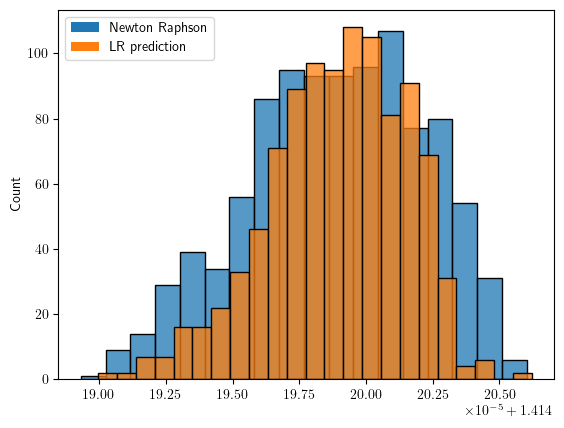

In [259]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_lr_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','LR prediction', '_A_'])
plt.savefig('./figures/kernel-montecarlo-lr.png')

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 49 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


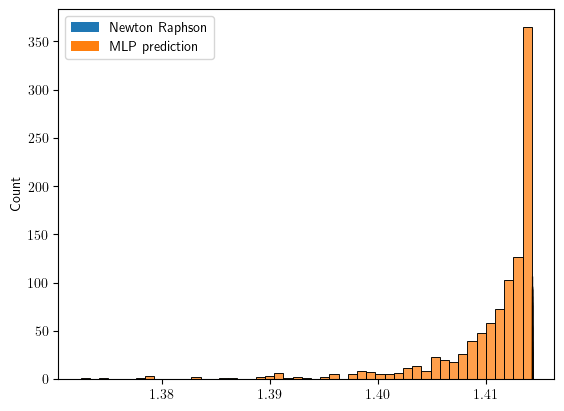

In [260]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_mlp_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','MLP prediction', '_A_'])
plt.savefig('./figures/kernel-montecarlo-mlp.png')

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 1 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


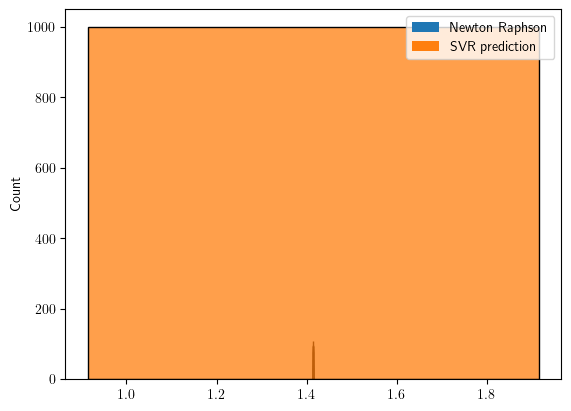

In [261]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_svr_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','SVR prediction', '_A_'])
plt.savefig('./figures/kernel-montecarlo-svr.png')

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 17 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


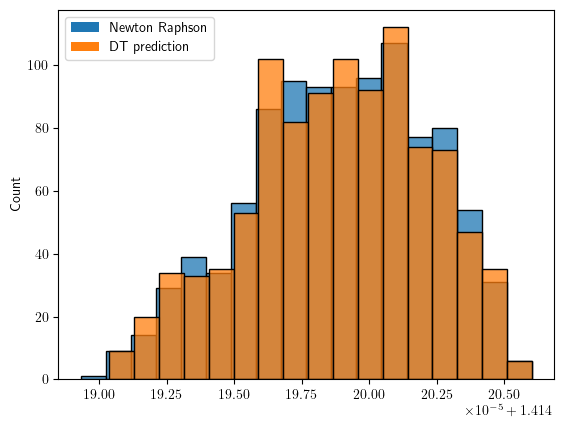

In [262]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_dt_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','DT prediction', '_A_'])
plt.savefig('./figures/kernel-montecarlo-dt.png')

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 19 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


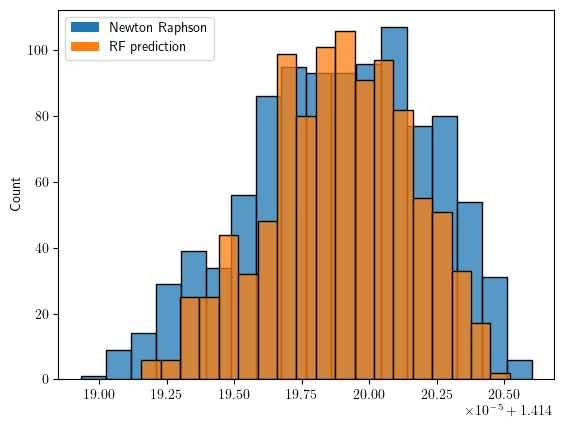

In [263]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_rf_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','RF prediction', '_A_'])
plt.savefig('./figures/kernel-montecarlo-rf.png')

### Heat map

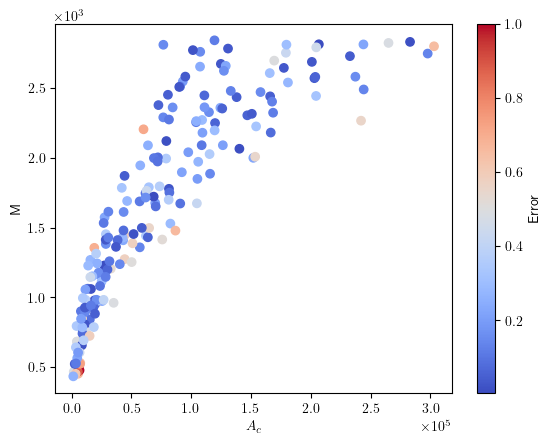

In [21]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_k)
col1 = np.abs(y_test_k - y_predict_rf_k)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-kernel-error-predictwithclass.eps',format='eps',dpi=300)
plt.show()

### Heat map

<Figure size 640x480 with 0 Axes>

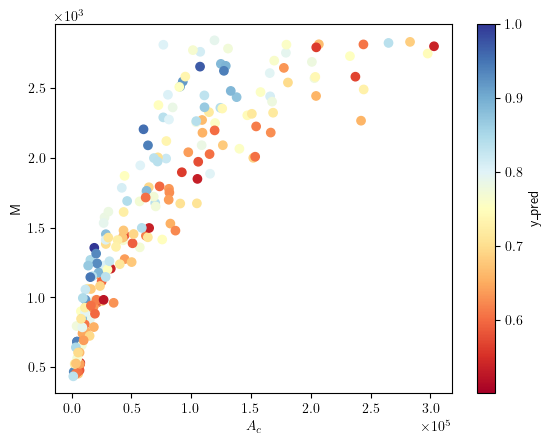

In [22]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_k)
col1 = y_test_k
col1 = col1/col1.max()
plt.show()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='RdYlBu')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"y_pred"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-kernel-real.eps',format='eps',dpi=300)
plt.show()

In [23]:
print(X_train_k_std.shape)
print(y_train_k.shape)

(800, 6)
(800,)


In [24]:
# # TENSORFLOW
# def build_model():
#     model = keras.Sequential([
#         layers.Conv1D(16, 1, input_shape=[X_train_b_std.shape[1],1]),
#         layers.Conv1D(8, 1),
#         layers.Conv1D(4, 1),
#         #layers.Dense(32, activation='relu', input_shape=[X_train_b_std.shape[1]]),
#         #layers.Dropout(0.1),
#         #layers.Dense(16, activation='relu'),
#         #layers.Dropout(0.1),
#         layers.Flatten(),
#         layers.Dense(4, activation='relu'),
#         #layers.Dropout(0.1),
#         layers.Dense(1, activation='linear')
#     ])

#     optimizer = tf.keras.optimizers.Adam(0.001)

#     model.compile(loss='mse',
#         optimizer=optimizer,
#         metrics=['mae', 'mse'])
#     return model


# model = build_model()
# model.summary()

# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Abs Error [Strain]')
#     plt.plot(hist['epoch'], hist['mae'])
#     plt.ylabel('Mean Square Error [$Strain^2$]')
#     plt.plot(hist['epoch'], hist['mse'], label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
#     plt.legend()
#     plt.show()


# #early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, min_delta=1e-10)


# history = model.fit(X_train_b_std, y_train_b, epochs=1000, validation_split = 0.2, verbose=1)

# plot_history(history)

# test_predictions = model.predict(X_test_b_b_std).flatten()

# print(test_predictions.shape)
# print(y_test_b.shape)

# plt.scatter(y_test_b, test_predictions)
# plt.xlabel('True Values [Strain]')
# plt.ylabel('Predictions [Strain]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _ = plt.plot([-100, 100], [-100, 100])
# plt.show()

# error = test_predictions - y_test_b
# plt.hist(error, bins = 25)
# plt.xlabel("Prediction Error [Strain]")
# _ = plt.ylabel("Count")
# plt.show()

# rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_b, test_predictions))
# mae_mlp = metrics.mean_absolute_error(y_test_b, test_predictions)
# r2_mlp = r2_score(y_test_b, test_predictions)
# mape_mlp = mean_absolute_percentage_error(y_test_b, test_predictions)

# print(f'RSME: {rmse_mlp} \n MAE: {mae_mlp} \n R2: {r2_mlp} \n MAPE: {mape_mlp} \n')

### TENSORFLOW
def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=[X_train_kb_std.shape[1]]),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse'])
    return model


model = build_model()
model.summary()

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Strain]')
    plt.plot(hist['epoch'], hist['mae'])
    plt.ylabel('Mean Square Error [$Strain^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.show()


#early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=15, min_delta=1e-10)


history = model.fit(X_train_kb_std, y_train_kb, epochs=1000, validation_split = 0.2, verbose=1)

plot_history(history)

test_predictions = model.predict(X_test_kb_std).flatten()

plt.scatter(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])
plt.xlabel('True Values [Strain]')
plt.ylabel('Predictions [Strain]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = test_predictions[y_test_class==1] - y_test_kb[y_test_class==1]
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Strain]")
_ = plt.ylabel("Count")
plt.show()

rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], test_predictions[y_test_class==1]))
mae_mlp = metrics.mean_absolute_error(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])
r2_mlp = r2_score(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])
mape_mlp = mean_absolute_percentage_error(y_test_kb[y_test_class==1], test_predictions[y_test_class==1])

print(f'RMSE: {rmse_mlp} \n MAE: {mae_mlp} \n R2: {r2_mlp} \n MAPE: {mape_mlp} \n')

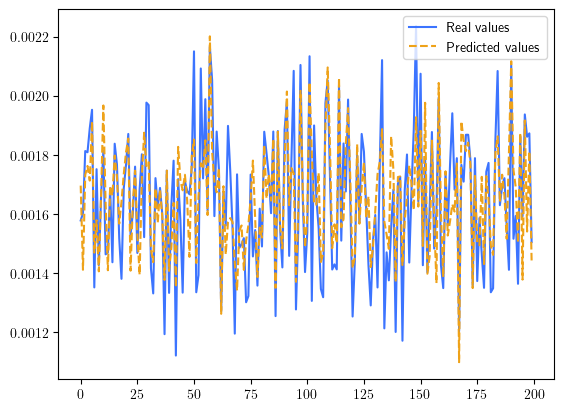

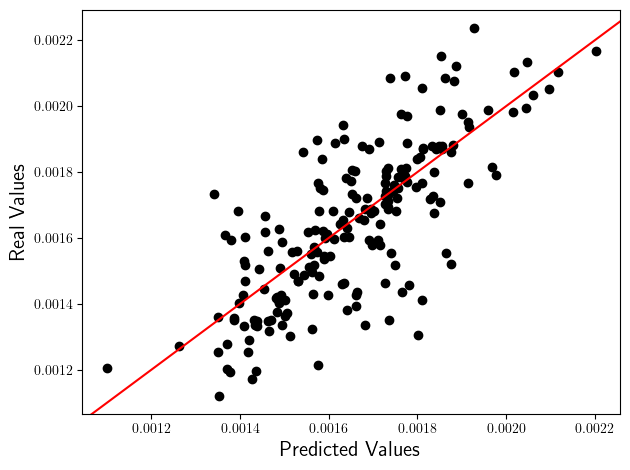

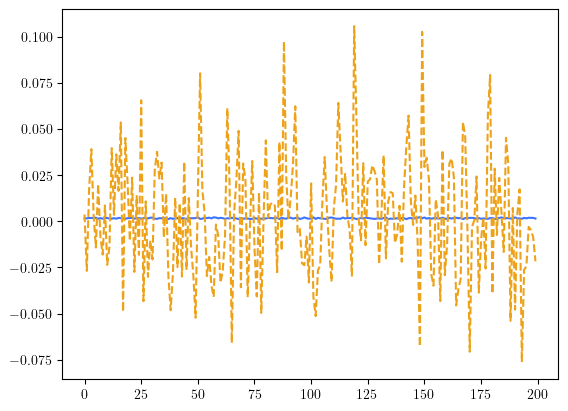

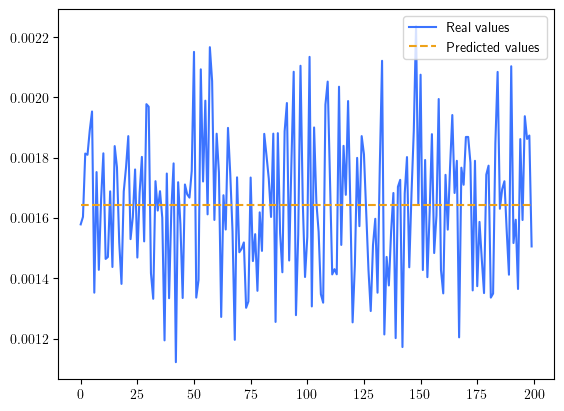

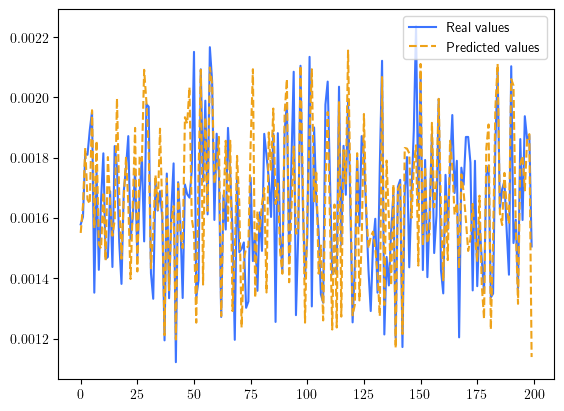

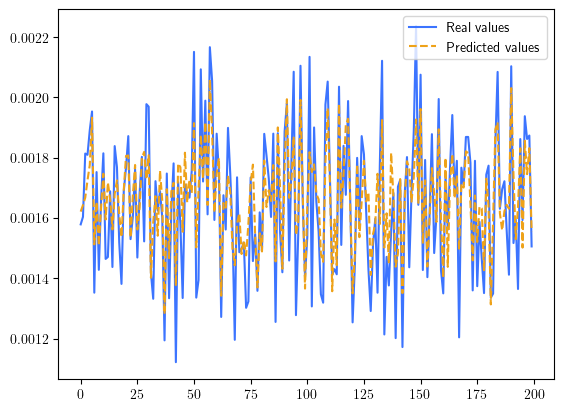

In [25]:
pretty_blue = '#3C74FF'
nice_orange = '#EEA219'

x=np.arange(0,len(y_test_k),1)

fig1_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_lr_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig_true_predict_k, ax = plt.subplots()
plt.plot(y_predict_lr_k, y_test_k, 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/kernel-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

fig2_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_mlp_k, '--', color=nice_orange, label='Predicted values')

fig3_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_svr_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_dt_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig5_k = plt.figure()
plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_rf_k, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

#fig6_k = plt.figure()
#plt.plot(x,y_test_k, '-', color=pretty_blue, label='Real values')
#plt.plot(x,test_predictions, '--', color=nice_orange, label='Predicted values')
#plt.legend()
#plt.show()


### Kernel --> Bound

In [26]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [27]:
lr = LinearRegression()
lr.fit(X_train_k_std, y_train_k)
y_predict_lr_k = lr.predict(X_test_k_b_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_k_std, y_train_k)
y_predict_svr_k = svr.predict(X_test_k_b_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_k_std, y_train_k)
    y_predict_dt_k = dt.predict(X_test_k_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_dt_k)
    mse = metrics.mean_squared_error(y_test_b, y_predict_dt_k)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_k_std, y_train_k)
    y_predict_rf_k = rf.predict(X_test_k_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_rf_k)
    mse = metrics.mean_squared_error(y_test_b, y_predict_rf_k)
    mae_rf.append(mae)
    mse_rf.append(mse)  

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_lr_k))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_svr_k))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_dt_k))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_rf_k))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )



 0.0008213524337414921 
 0.0010964524563809273 
 9.016870959711121e-07 
 9.204410960210366e-07 



## Testing the Bound

### Bound --> Bound

In [28]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel_bound_forKernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
#y_test_k = data_k_test.values[:, -1]

#### Regression models

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

mlp = MLPRegressor(learning_rate='adaptive')
mlp.fit(X_train_b_std, y_train_b)
y_predict_mlp_b = mlp.predict(X_test_b_b_std)

lr = LinearRegression()
lr.fit(X_train_b_std, y_train_b)
y_predict_lr_b = lr.predict(X_test_b_b_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_b_std, y_train_b)
y_predict_svr_b = svr.predict(X_test_b_b_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
rmse_dt = []
r2_dt = []
mape_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_b_std, y_train_b)
    y_predict_dt_b = dt.predict(X_test_b_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_dt_b)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_dt_b))
    r2 = r2_score(y_test_b, y_predict_dt_b)
    mape = mean_absolute_percentage_error(y_test_b, y_predict_dt_b)
    mae_dt.append(mae)
    rmse_dt.append(rmse)
    r2_dt.append(r2)
    mape_dt.append(mape)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

mae_rf = []
rmse_rf = []
r2_rf = []
mape_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_b_std, y_train_b)
    y_predict_rf_b = rf.predict(X_test_b_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_rf_b)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_rf_b))
    r2 = r2_score(y_test_b, y_predict_rf_b)
    mape = mean_absolute_percentage_error(y_test_b, y_predict_rf_b)
    mae_rf.append(mae)
    rmse_rf.append(rmse)
    r2_rf.append(r2)
    mape_rf.append(mape)
    # plt.plot(y_test_k)
    # plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_lr_b))
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_mlp_b))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_svr_b))
rmse_dt = np.mean(rmse_dt)
rmse_rf = np.mean(rmse_rf)
mae_lr = metrics.mean_absolute_error(y_test_b, y_predict_lr_b)
mae_mlp = metrics.mean_absolute_error(y_test_b, y_predict_mlp_b)
mae_svr = metrics.mean_absolute_error(y_test_b, y_predict_svr_b)
mae_dt = np.mean(mae_dt)
mae_rf = np.mean(mae_rf)
r2_lr = r2_score(y_test_b, y_predict_lr_b)
r2_mlp = r2_score(y_test_b, y_predict_mlp_b)
r2_svr = r2_score(y_test_b, y_predict_svr_b)
r2_dt = np.mean(r2_dt)
r2_rf = np.mean(r2_rf)
mape_lr = mean_absolute_percentage_error(y_test_b, y_predict_svr_b)
mape_mlp = mean_absolute_percentage_error(y_test_b, y_predict_mlp_b)
mape_svr = mean_absolute_percentage_error(y_test_b, y_predict_svr_b)
mape_dt = np.mean(mape_dt)
mape_rf = np.mean(mape_rf)

print('Root Mean Squared Error:''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error:''\n', 'LR: ''\t', mae_lr, '\n', 'MLP: ''\t', mae_mlp, '\n', 'SVR: ''\t', mae_svr, '\n', 'DT: ''\t', mae_dt, '\n', 'RF: ''\t', mae_rf, '\n', )
print('R2 Score:''\n', 'LR: ''\t', r2_lr, '\n', 'MLP: ''\t', r2_mlp, '\n', 'SVR: ''\t', r2_svr, '\n', 'DT: ''\t', r2_dt, '\n', 'RF: ''\t', r2_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_lr, '\n', 'MLP: ''\t', mape_mlp, '\n', 'SVR: ''\t', mape_svr, '\n', 'DT: ''\t', mape_dt, '\n', 'RF: ''\t', mape_rf, '\n', )

Root Mean Squared Error:
 LR: 	 4.892117561734624e-06 
 MLP: 	 0.03506534031183792 
 SVR: 	 6.814628817718981e-05 
 DT: 	 1.205364376859744e-05 
 RF: 	 7.3807190154782e-06 

Mean Absolute Error:
 LR: 	 4.036138039712154e-06 
 MLP: 	 0.02606341988546039 
 SVR: 	 5.5669628356657584e-05 
 DT: 	 9.365063334511117e-06 
 RF: 	 5.688587107205956e-06 

R2 Score:
 LR: 	 0.994023752895413 
 MLP: 	 -307036.12627711176 
 SVR: 	 -0.15962931952130366 
 DT: 	 0.9637059447419933 
 RF: 	 0.9863924637758423 

MAPE Score:
 LR: 	 0.10024183366687821 
 MLP: 	 47.6704264520391 
 SVR: 	 0.10024183366687821 
 DT: 	 0.01733888789382884 
 RF: 	 0.010635888912402231 



#### ML vs True comparison

In [30]:
test_df_b = X_test_b.copy()
test_df_b.rename(columns={0:'E_s',1:'f_y',2:'f_ct',3:'A_s',4:'A_c',5:'M'})
test_df_b.insert(len(test_df_b.columns), 'true', y_test_b)
test_df_b.insert(len(test_df_b.columns), 'lr_predict', y_predict_lr_b)
test_df_b.insert(len(test_df_b.columns), 'mlp_predict', y_predict_mlp_b)
test_df_b.insert(len(test_df_b.columns), 'svr_predict', y_predict_svr_b)
test_df_b.insert(len(test_df_b.columns), 'dt_predict', y_predict_dt_b)
test_df_b.insert(len(test_df_b.columns), 'rf_predict', y_predict_rf_b)
test_df_b

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
508,198459.496593,452.538958,2.829857,1174.790167,477050.793272,2769.924019,0.000610,0.000608,0.034468,0.000524,0.000594,0.000607
159,200187.789867,408.520241,3.517273,1043.098642,289843.213244,2610.059421,0.000535,0.000533,-0.045003,0.000524,0.000520,0.000528
331,203267.042558,422.919802,4.013805,1058.263695,269224.529482,2628.964086,0.000547,0.000543,0.005322,0.000524,0.000555,0.000548
358,197003.075783,438.127808,2.688719,195.410011,59882.814903,1129.694746,0.000519,0.000513,-0.000653,0.000524,0.000524,0.000521
137,199163.595889,435.175613,2.806765,385.738907,124134.008787,1587.210133,0.000539,0.000540,-0.012390,0.000524,0.000548,0.000540
...,...,...,...,...,...,...,...,...,...,...,...,...
985,201744.757775,471.434971,2.567334,269.264238,99069.494456,1326.102345,0.000566,0.000562,0.007313,0.000524,0.000577,0.000576
381,200863.633678,413.037013,2.647694,633.002949,217728.235346,2033.249018,0.000521,0.000528,-0.030185,0.000524,0.000528,0.000521
981,204239.068536,423.669606,2.845433,801.504580,274492.516491,2287.919338,0.000535,0.000540,-0.009080,0.000524,0.000544,0.000540
850,201022.954762,462.257785,3.734790,1082.478019,336323.362809,2658.870882,0.000613,0.000608,-0.007986,0.000524,0.000606,0.000612


In [31]:
train_df_b = X_train_b.copy()
train_df_b.rename(columns={0:'E_s',1:'f_y',2:'f_ct',3:'A_s',4:'A_c',5:'M'})
train_df_b.insert(len(train_df_b.columns), 'true', y_train_b)
train_df_b.insert(len(train_df_b.columns), 'lr_predict', lr.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'mlp_predict', mlp.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'svr_predict', svr.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'dt_predict', dt.predict(X_train_b_std))
train_df_b.insert(len(train_df_b.columns), 'rf_predict', rf.predict(X_train_b_std))
train_df_b

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
387,204246.748691,466.050986,3.054298,138.055916,37955.821580,949.544265,0.000518,0.000511,-0.003898,0.000524,0.000518,0.000520
39,203283.369269,488.944381,2.841487,993.081086,429241.121319,2546.713321,0.000641,0.000644,0.014813,0.000524,0.000641,0.000644
789,199317.620312,420.933140,2.632642,37.879506,9064.667722,497.381765,0.000404,0.000409,0.007371,0.000524,0.000404,0.000404
940,199541.016429,492.334673,2.673922,1188.407387,572678.445349,2785.931130,0.000666,0.000666,-0.003391,0.000524,0.000666,0.000666
134,197247.889332,485.497148,2.839611,195.379436,64749.107223,1129.606364,0.000585,0.000578,0.027401,0.000524,0.000585,0.000585
...,...,...,...,...,...,...,...,...,...,...,...,...
904,195251.178609,451.159108,3.154998,1017.216573,361783.964505,2577.474744,0.000614,0.000613,0.006851,0.000524,0.000614,0.000612
525,204144.070998,468.003346,3.683665,637.042752,185229.838510,2039.726763,0.000590,0.000594,-0.005096,0.000524,0.000590,0.000593
899,201169.241761,402.134301,3.770330,1244.733230,325155.749270,2851.187949,0.000528,0.000519,-0.006877,0.000524,0.000528,0.000527
512,199999.961046,412.954659,3.306811,46.217526,8793.113722,549.403033,0.000403,0.000404,0.025802,0.000524,0.000403,0.000404


In [32]:
df_b = pd.concat([train_df_b, test_df_b], ignore_index=True, axis=0)
df_b.to_csv(f'./data/boundary{n_bound}-with-predictions.csv', index=False)
df_b

,0,1,2,3,4,5,true,lr_predict,mlp_predict,svr_predict,dt_predict,rf_predict
0,204246.748691,466.050986,3.054298,138.055916,37955.821580,949.544265,0.000518,0.000511,-0.003898,0.000524,0.000518,0.000520
1,203283.369269,488.944381,2.841487,993.081086,429241.121319,2546.713321,0.000641,0.000644,0.014813,0.000524,0.000641,0.000644
2,199317.620312,420.933140,2.632642,37.879506,9064.667722,497.381765,0.000404,0.000409,0.007371,0.000524,0.000404,0.000404
3,199541.016429,492.334673,2.673922,1188.407387,572678.445349,2785.931130,0.000666,0.000666,-0.003391,0.000524,0.000666,0.000666
4,197247.889332,485.497148,2.839611,195.379436,64749.107223,1129.606364,0.000585,0.000578,0.027401,0.000524,0.000585,0.000585
...,...,...,...,...,...,...,...,...,...,...,...,...
995,201744.757775,471.434971,2.567334,269.264238,99069.494456,1326.102345,0.000566,0.000562,0.007313,0.000524,0.000577,0.000576
996,200863.633678,413.037013,2.647694,633.002949,217728.235346,2033.249018,0.000521,0.000528,-0.030185,0.000524,0.000528,0.000521
997,204239.068536,423.669606,2.845433,801.504580,274492.516491,2287.919338,0.000535,0.000540,-0.009080,0.000524,0.000544,0.000540
998,201022.954762,462.257785,3.734790,1082.478019,336323.362809,2658.870882,0.000613,0.000608,-0.007986,0.000524,0.000606,0.000612


##### Monte-carlo sampling

In [251]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_true = rbf_feature.fit_transform(np.reshape([df_b.get('true')], (1000, 1)))

# d_lr_pred =rbf_feature.transform(np.reshape([df_b.get('lr_predict')], (1000, 1))) 

# d_mlp_pred =rbf_feature.transform(np.reshape([df_b.get('mlp_predict')], (1000, 1))) 

# d_svr_pred =rbf_feature.transform(np.reshape([df_b.get('svr_predict')], (1000, 1))) 

# d_dt_pred =rbf_feature.transform(np.reshape([df_b.get('dt_predict')], (1000, 1))) 

# d_rf_pred =rbf_feature.transform(np.reshape([df_b.get('rf_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_lr_pred =rbf_feature.fit_transform(np.reshape([df_b.get('lr_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_mlp_pred =rbf_feature.fit_transform(np.reshape([df_b.get('mlp_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_svr_pred =rbf_feature.fit_transform(np.reshape([df_b.get('svr_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_dt_pred =rbf_feature.fit_transform(np.reshape([df_b.get('dt_predict')], (1000, 1))) 

rbf_feature = RBFSampler(gamma = 1, random_state = 1, n_components=1)
d_rf_pred =rbf_feature.fit_transform(np.reshape([df_b.get('rf_predict')], (1000, 1))) 

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


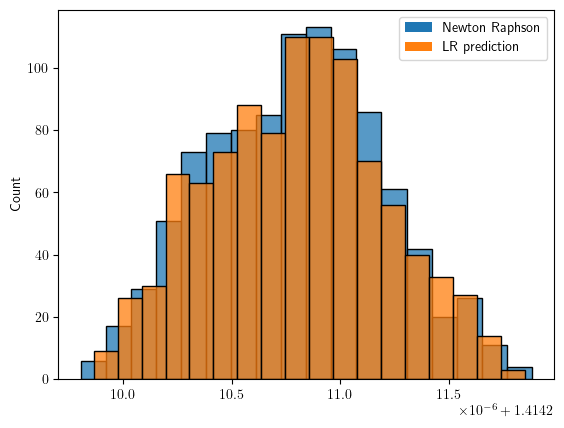

In [252]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_lr_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','LR prediction', '_A_'])
plt.savefig('./figures/bound-montecarlo-lr.png')

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 84 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


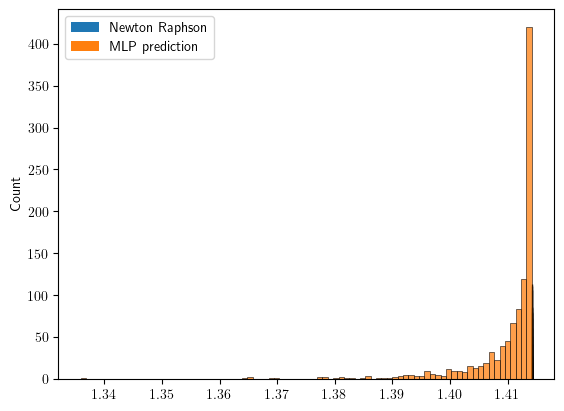

In [253]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_mlp_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','MLP prediction', '_A_'])
plt.savefig('./figures/bound-montecarlo-mlp.png')

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 1 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


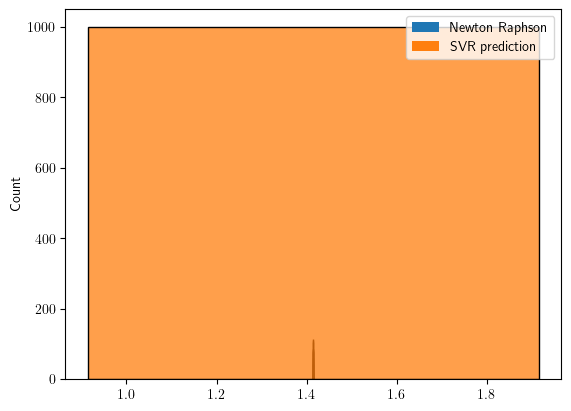

In [254]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_svr_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','SVR prediction', '_A_'])
plt.savefig('./figures/bound-montecarlo-svr.png')

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 19 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


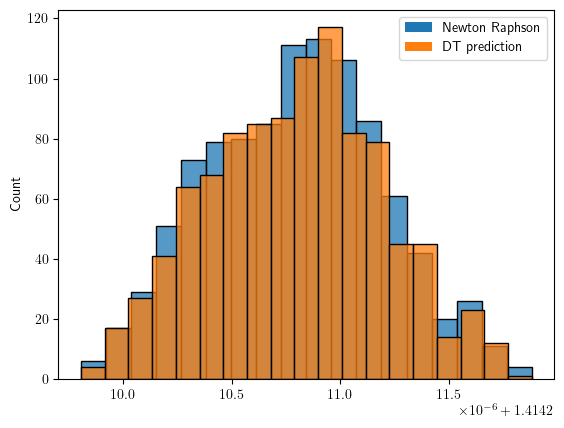

In [255]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_dt_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','DT prediction', '_A_'])
plt.savefig('./figures/bound-montecarlo-dt.png')

/home/cosmin/anaconda3/envs/CFGRIB/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The handle <BarContainer object of 18 artists> has a label of '_A_' which cannot be automatically added to the legend.
  This is separate from the ipykernel package so we can avoid doing imports until


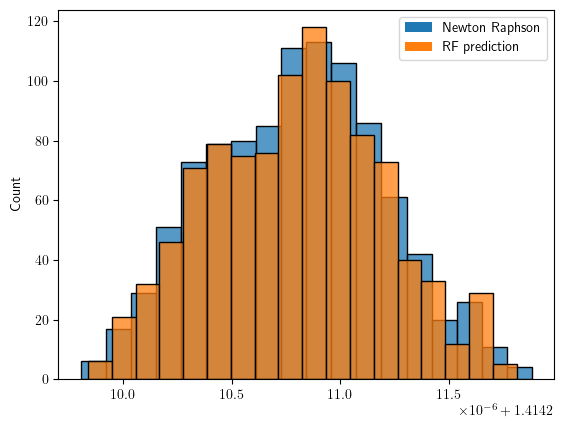

In [256]:
sns.histplot(np.array(d_true).flatten(), legend=False)
sns.histplot(np.array(d_rf_pred).flatten(), legend=False)
plt.legend(labels = ['Newton Raphson', '_A_','RF prediction', '_A_'])
plt.savefig('./figures/bound-montecarlo-rf.png')

### Heat map

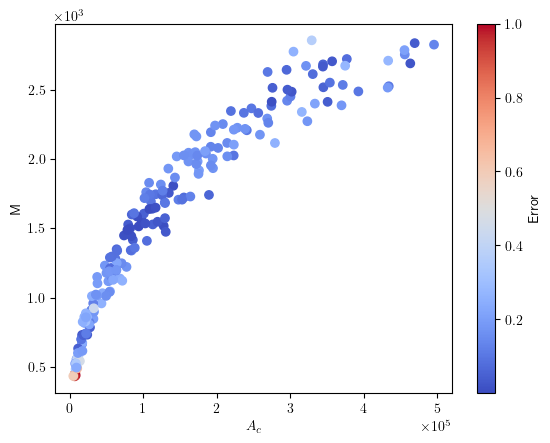

In [272]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_b)
col1 = np.abs(y_test_b - y_predict_lr_b)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-bound-error-predictwithclass.eps',format='eps',dpi=300)
plt.show()

In [273]:
#X_test_heatmap_b = pd.DataFrame(X_test_b)
#X_test_heatmap_b = X_test_heatmap_b.assign(A = y_predict_lr_b)
#X_test_heatmap_b = X_test_heatmap_b.drop(columns=[0,1,2,5])
#X_test_heatmap_b.to_csv("predict-bound.csv",index=False, header=False)

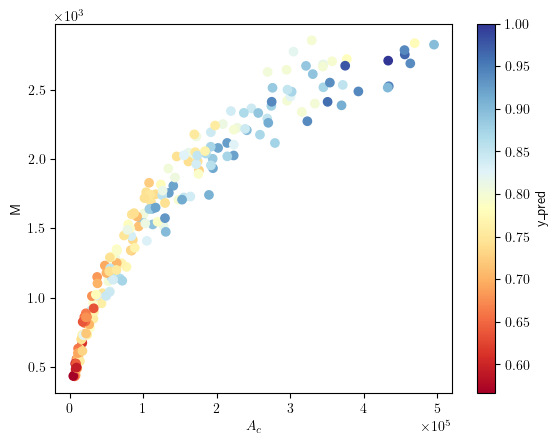

In [274]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_b)
col2 = y_test_b
col2 = col2/col2.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col2, cmap='RdYlBu')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"y_pred"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-bound-real.eps',format='eps',dpi=300)
plt.show()

In [275]:
col_bool = col1 == col2
col_bool[col_bool==True]

Series([], Name: 6, dtype: bool)

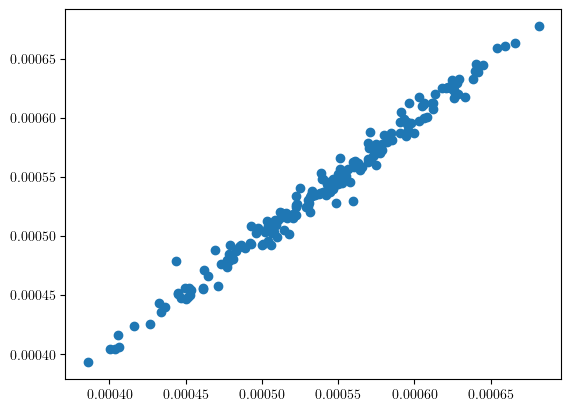

In [276]:
figsct_b1 = plt.figure()
plt.scatter(y_test_b, y_predict_rf_b)


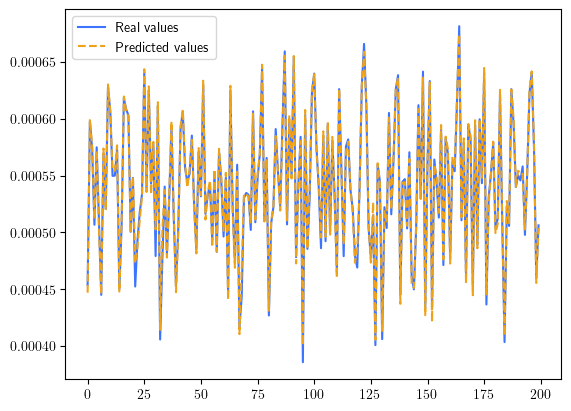

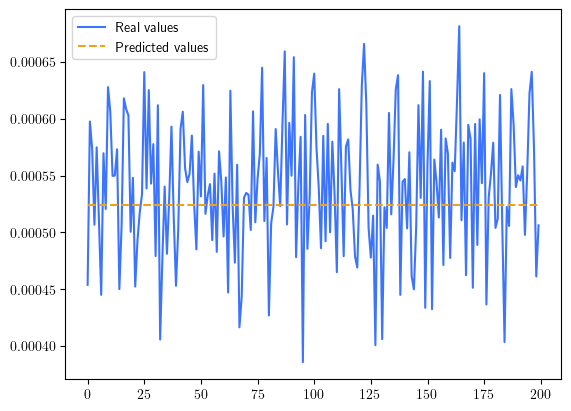

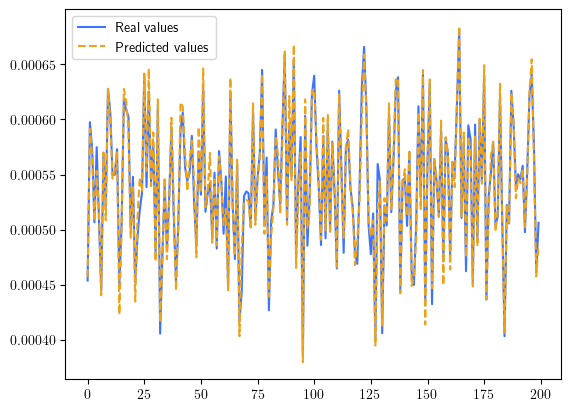

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


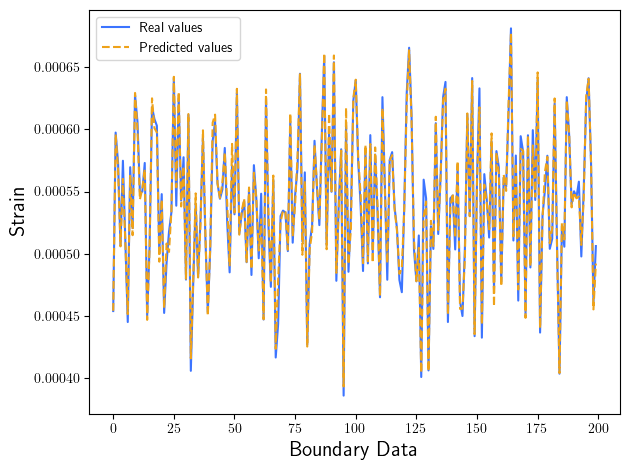

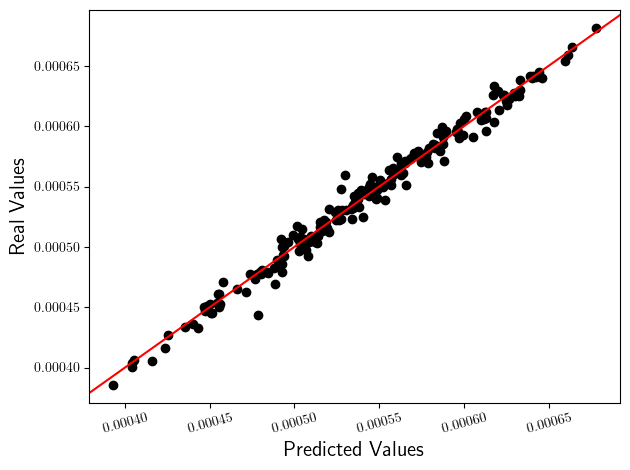

In [277]:
x=np.arange(0,len(y_test_b),1)

fig1_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_lr_b, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig2_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_svr_b, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig3_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_dt_b, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4_b = plt.figure()
plt.plot(x,y_test_b, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_rf_b, '--', color=nice_orange, label='Predicted values')
plt.xlabel('Boundary Data', fontsize=15)
plt.ylabel('Strain', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/bound-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/bound-regression.svg')
plt.show()

fig_true_predict_b, ax = plt.subplots()
plt.plot(y_predict_rf_b, y_test_b, 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('./figures/bound-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

### Bound --> Kernel

In [278]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [279]:
lr = LinearRegression()
lr.fit(X_train_b_std, y_train_b)
y_predict_lr_b = lr.predict(X_test_b_k_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_b_std, y_train_b)
y_predict_svr_b = svr.predict(X_test_b_k_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_b_std, y_train_b)
    y_predict_dt_b = dt.predict(X_test_b_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_dt_b)
    mse = metrics.mean_squared_error(y_test_k, y_predict_dt_b)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_b_std, y_train_b)
    y_predict_rf_b = rf.predict(X_test_b_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_rf_b)
    mse = metrics.mean_squared_error(y_test_k, y_predict_rf_b)
    mae_rf.append(mae)
    mse_rf.append(mse)  

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_lr_b))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_svr_b))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_dt_b))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_rf_b))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )





 0.0011378512843957284 
 0.0011578014799446578 
 1.3208186984448841e-06 
 1.3249910019900012e-06 



## Testing the Kernel + Bound

### Kernel + Bound --> Kernel

In [280]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel_bound_forKernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#### Regression models

In [281]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

lr = LinearRegression()
lr.fit(X_train_kb_std, y_train_kb)
y_predict_lr_kb = lr.predict(X_test_kb_k_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_kb_std, y_train_kb)
y_predict_svr_kb = svr.predict(X_test_kb_k_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_kb_std, y_train_kb)
    y_predict_dt_kb = dt.predict(X_test_kb_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_dt_kb)
    mse = metrics.mean_squared_error(y_test_k, y_predict_dt_kb)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_kb_std, y_train_kb)
    y_predict_rf_kb = rf.predict(X_test_kb_k_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_k, y_predict_rf_kb)
    mse = metrics.mean_squared_error(y_test_k, y_predict_rf_kb)
    mae_rf.append(mae)
    mse_rf.append(mse)
    # plt.plot(y_test_k)
    # plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_lr_kb))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_svr_kb))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_dt_k))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_k, y_predict_rf_k))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )
#print(mse_dt, mse_rf)


 0.00041528025290052005 
 0.00045038440231621915 
 1.0032406591091807e-07 
 4.0111013218145264e-08 



### Kernel + Bound --> Bound

In [282]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [283]:
lr = LinearRegression()
lr.fit(X_train_kb_std, y_train_kb)
y_predict_lr_kb = lr.predict(X_test_kb_b_std)
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_kb_std, y_train_kb)
y_predict_svr_kb = svr.predict(X_test_kb_b_std)
# plt.plot(y_predict_svr_k)

mae_dt = []
mse_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_kb_std, y_train_kb)
    y_predict_dt_kb = dt.predict(X_test_kb_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_dt_kb)
    mse = metrics.mean_squared_error(y_test_b, y_predict_dt_kb)
    mae_dt.append(mae)
    mse_dt.append(mse)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
mse_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_kb_std, y_train_kb)
    y_predict_rf_kb = rf.predict(X_test_kb_b_std)
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_b, y_predict_rf_kb)
    mse = metrics.mean_squared_error(y_test_b, y_predict_rf_kb)
    mae_rf.append(mae)
    mse_rf.append(mse)  

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_lr_kb))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_svr_kb))
#rmse_dt = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_dt_k))
#rmse_rf = np.sqrt(metrics.mean_squared_error(y_test_b, y_predict_rf_k))
rmse_dt = np.mean(mse_dt)
rmse_rf = np.mean(mse_rf)
print('\n', rmse_lr, '\n', rmse_svr, '\n', rmse_dt, '\n', rmse_rf, '\n', )



 0.00041313630624048 
 0.0007310511329927781 
 6.710214459350814e-08 
 2.256071499359043e-08 



### Kernel + Bound --> Kernel + Bound

In [284]:
#Kernel data
#Train data
#data_k_train = pd.read_excel('train_kernel.xlsx') #this data contains samples from kernel (80%) and whole bound
#X_train_k = data_k_train.values[:, :-1]
#y_train_k = data_k_train.values[:, -1]
#Test data
#data_k_test = pd.read_excel('test_kernel.xlsx')
#X_test_k = data_k_test.values[:, :-1]
#y_test_k = data_k_test.values[:, -1]

#std = StandardScaler()
#X_train_k_std = std.fit_transform(X_train_k, y_train_k)
#X_test_k_std = std.transform(X_test_k)

#### Regression Models

In [285]:
mlp = MLPRegressor(learning_rate='adaptive')
mlp.fit(X_train_kb_std, y_train_kb)
y_predict_mlp_kb = mlp.predict(X_test_kb_std)
y_predict_mlp_kernel = y_predict_mlp_kb[y_test_class==0]
y_predict_mlp_bound = y_predict_mlp_kb[y_test_class==1]

lr = LinearRegression()
lr.fit(X_train_kb_std, y_train_kb)
y_predict_lr_kb = lr.predict(X_test_kb_std)
y_predict_lr_kernel = y_predict_lr_kb[y_test_class==0]
y_predict_lr_bound = y_predict_lr_kb[y_test_class==1]
# plt.scatter(np.arange(len(y_test_k)), y_predict_lr_k, linewidth=5)
# plt.plot(y_predict_lr_k)

svr = SVR()
svr.fit(X_train_kb_std, y_train_kb)
y_predict_svr_kb = svr.predict(X_test_kb_std)
y_predict_svr_kernel = y_predict_svr_kb[y_test_class==0]
y_predict_svr_bound = y_predict_svr_kb[y_test_class==1]
# plt.plot(y_predict_svr_k)

mae_dt = []
rmse_dt = []
r2_dt = []
mape_dt = []

mae_k_dt = []
rmse_k_dt = []
r2_k_dt = []
mape_k_dt = []

mae_b_dt = []
rmse_b_dt = []
r2_b_dt = []
mape_b_dt = []
for r in range(5):
    dt = DecisionTreeRegressor()
    dt.fit(X_train_kb_std, y_train_kb)
    y_predict_dt_kb = dt.predict(X_test_kb_std)
    y_predict_dt_kernel = y_predict_dt_kb[y_test_class==0]
    y_predict_dt_bound = y_predict_dt_kb[y_test_class==1]
    #mae = metrics.mean_absolute_error(y_test, y_predict_dt)
    #mse = metrics.mean_squared_error(y_test, y_predict_dt)
    mae = metrics.mean_absolute_error(y_test_kb, y_predict_dt_kb)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_dt_kb))
    r2 = r2_score(y_test_kb, y_predict_dt_kb)
    mape = mean_absolute_percentage_error(y_test_kb, y_predict_dt_kb)

    mae_k = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_dt_kernel)
    rmse_k = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_dt_kernel))
    r2_k = r2_score(y_test_kb[y_test_class==0], y_predict_dt_kernel)
    mape_k = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_dt_kernel)

    mae_b = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_dt_bound)
    rmse_b = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_dt_bound))
    r2_b = r2_score(y_test_kb[y_test_class==1], y_predict_dt_bound)
    mape_b = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_dt_bound)

    mae_dt.append(mae)
    rmse_dt.append(rmse)
    r2_dt.append(r2)
    mape_dt.append(mape)

    mae_k_dt.append(mae_k)
    rmse_k_dt.append(rmse_k)
    r2_k_dt.append(r2_k)
    mape_k_dt.append(mape_k)

    mae_b_dt.append(mae_b)
    rmse_b_dt.append(rmse_b)
    r2_b_dt.append(r2_b)
    mape_b_dt.append(mape_b)
    # plt.plot(y_test_k)
    # plt.plot(y_predict_dt_k)

    
mae_rf = []
rmse_rf = []
r2_rf = []
mape_rf = []

mae_k_rf = []
rmse_k_rf = []
r2_k_rf = []
mape_k_rf= []

mae_b_rf = []
rmse_b_rf = []
r2_b_rf = []
mape_b_rf = []
for r in range(5):
    rf = RandomForestRegressor()
    rf.fit(X_train_kb_std, y_train_kb)
    y_predict_rf_kb = rf.predict(X_test_kb_std)
    y_predict_rf_kernel = y_predict_rf_kb[y_test_class==0]
    y_predict_rf_bound = y_predict_rf_kb[y_test_class==1]
    #mae = metrics.mean_absolute_error(y_test, y_predict_rf)
    #mse = metrics.mean_squared_error(y_test, y_predict_rf)
    mae = metrics.mean_absolute_error(y_test_kb, y_predict_rf_kb)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_rf_kb))
    r2 = r2_score(y_test_kb, y_predict_rf_kb)
    mape = mean_absolute_percentage_error(y_test_kb, y_predict_rf_kb)

    mae_k = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_rf_kernel)
    rmse_k = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_rf_kernel))
    r2_k = r2_score(y_test_kb[y_test_class==0], y_predict_rf_kernel)
    mpae_k = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_rf_kernel)

    mae_b = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_rf_bound)
    rmse_b = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_rf_bound))
    r2_b = r2_score(y_test_kb[y_test_class==1], y_predict_rf_bound)
    mape_b = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_rf_bound)

    mae_rf.append(mae)
    rmse_rf.append(rmse)  
    r2_rf.append(r2)
    mape_rf.append(mape)

    mae_k_rf.append(mae_k)
    rmse_k_rf.append(rmse_k)  
    r2_k_rf.append(r2_k)
    mape_k_rf.append(mape_k)

    mae_b_rf.append(mae_b)
    rmse_b_rf.append(rmse_b)  
    r2_b_rf.append(r2_b)
    mape_b_rf.append(mape_b)

#rf = RandomForestRegressor()
#rf.fit(X_train_k_std, y_train_k)
#y_predict_rf_k = rf.predict(X_test_k_b_std)
# plt.plot(y_test_k)
# plt.scatter(np.arange(len(y_test_k)), y_predict_rf_k, linewidth=5)


rmse_lr = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_lr_kb))
rmse_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_mlp_kb))
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test_kb, y_predict_svr_kb))
rmse_dt = np.mean(rmse_dt)
rmse_rf = np.mean(rmse_rf)
mae_lr = metrics.mean_absolute_error(y_test_kb, y_predict_lr_kb)
mae_mlp = metrics.mean_absolute_error(y_test_kb, y_predict_mlp_kb)
mae_svr = metrics.mean_absolute_error(y_test_kb, y_predict_svr_kb)
mae_dt = np.mean(mae_dt)
mae_rf = np.mean(mae_rf)
r2_lr = r2_score(y_test_kb, y_predict_lr_kb)
r2_mlp = r2_score(y_test_kb, y_predict_mlp_kb)
r2_svr = r2_score(y_test_kb, y_predict_svr_kb)
r2_dt = np.mean(r2_dt)
r2_rf = np.mean(r2_rf)
mape_lr = mean_absolute_percentage_error(y_test_kb, y_predict_svr_kb)
mape_mlp = mean_absolute_percentage_error(y_test_kb, y_predict_mlp_kb)
mape_svr = mean_absolute_percentage_error(y_test_kb, y_predict_svr_kb)
mape_dt = np.mean(mape_dt)
mape_rf = np.mean(mape_rf)

rmse_k_lr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_lr_kernel))
rmse_k_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_mlp_kernel))
rmse_k_svr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==0], y_predict_svr_kernel))
rmse_k_dt = np.mean(rmse_k_dt)
rmse_k_rf = np.mean(rmse_k_rf)
mae_k_lr = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_lr_kernel)
mae_k_mlp = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_mlp_kernel)
mae_k_svr = metrics.mean_absolute_error(y_test_kb[y_test_class==0], y_predict_svr_kernel)
mae_k_dt = np.mean(mae_k_dt)
mae_k_rf = np.mean(mae_k_rf)
r2_k_lr = r2_score(y_test_kb[y_test_class==0], y_predict_lr_kernel)
r2_k_mlp = r2_score(y_test_kb[y_test_class==0], y_predict_mlp_kernel)
r2_k_svr = r2_score(y_test_kb[y_test_class==0], y_predict_svr_kernel)
r2_k_dt = np.mean(r2_k_dt)
r2_k_rf = np.mean(r2_k_rf)
mape_k_lr = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_lr_kernel)
mape_k_mlp = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_mlp_kernel)
mape_k_svr = mean_absolute_percentage_error(y_test_kb[y_test_class==0], y_predict_svr_kernel)
mape_k_dt = np.mean(mape_k_dt)
mape_k_rf = np.mean(mape_k_rf)

rmse_b_lr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_lr_bound))
rmse_b_mlp = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_mlp_bound))
rmse_b_svr = np.sqrt(metrics.mean_squared_error(y_test_kb[y_test_class==1], y_predict_svr_bound))
rmse_b_dt = np.mean(rmse_b_dt)
rmse_b_rf = np.mean(rmse_b_rf)
mae_b_lr = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_lr_bound)
mae_b_mlp = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_mlp_bound)
mae_b_svr = metrics.mean_absolute_error(y_test_kb[y_test_class==1], y_predict_svr_bound)
mae_b_dt = np.mean(mae_b_dt)
mae_b_rf = np.mean(mae_b_rf)
r2_b_lr = r2_score(y_test_kb[y_test_class==1], y_predict_lr_bound)
r2_b_mlp = r2_score(y_test_kb[y_test_class==1], y_predict_mlp_bound)
r2_b_svr = r2_score(y_test_kb[y_test_class==1], y_predict_svr_bound)
r2_b_dt = np.mean(r2_b_dt)
r2_b_rf = np.mean(r2_b_rf)
mape_b_lr = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_lr_kernel)
mape_b_mlp = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_mlp_kernel)
mape_b_svr = mean_absolute_percentage_error(y_test_kb[y_test_class==1], y_predict_svr_kernel)
mape_b_dt = np.mean(mape_b_dt)
mape_b_rf = np.mean(mape_b_rf)

print('Root Mean Squared Error:''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error:''\n', 'LR: ''\t', mae_lr, '\n', 'MLP: ''\t', mae_mlp, '\n', 'SVR: ''\t', mae_svr, '\n', 'DT: ''\t', mae_dt, '\n', 'RF: ''\t', mae_rf, '\n', )
print('R2 Score:''\n', 'LR: ''\t', r2_lr, '\n', 'MLP: ''\t', r2_mlp, '\n', 'SVR: ''\t', r2_svr, '\n', 'DT: ''\t', r2_dt, '\n', 'RF: ''\t', r2_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_lr, '\n', 'MLP: ''\t', mape_mlp, '\n', 'SVR: ''\t', mape_svr, '\n', 'DT: ''\t', mape_dt, '\n', 'RF: ''\t', mape_rf, '\n', )

print('Root Mean Squared Error (kernel):''\n', 'LR: ''\t', rmse_k_lr, '\n', 'MLP: ''\t', rmse_k_mlp, '\n', 'SVR: ''\t', rmse_k_svr, '\n', 'DT: ''\t', rmse_k_dt, '\n', 'RF: ''\t', rmse_k_rf, '\n', )
print('Mean Absolute Error (kernel):''\n', 'LR: ''\t', mae_k_lr, '\n', 'MLP: ''\t', mae_k_mlp, '\n', 'SVR: ''\t', mae_k_svr, '\n', 'DT: ''\t', mae_k_dt, '\n', 'RF: ''\t', mae_k_rf, '\n', )
print('R2 Score (kernel):''\n', 'LR: ''\t', r2_k_lr, '\n', 'MLP: ''\t', r2_k_mlp, '\n', 'SVR: ''\t', r2_k_svr, '\n', 'DT: ''\t', r2_k_dt, '\n', 'RF: ''\t', r2_k_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_k_lr, '\n', 'MLP: ''\t', mape_k_mlp, '\n', 'SVR: ''\t', mape_k_svr, '\n', 'DT: ''\t', mape_k_dt, '\n', 'RF: ''\t', mape_k_rf, '\n', )

print('Root Mean Squared Error (bound):''\n', 'LR: ''\t', rmse_lr, '\n', 'MLP: ''\t', rmse_b_mlp, '\n', 'SVR: ''\t', rmse_svr, '\n', 'DT: ''\t', rmse_dt, '\n', 'RF: ''\t', rmse_rf, '\n', )
print('Mean Absolute Error (bound):''\n', 'LR: ''\t', mae_b_lr, '\n', 'MLP: ''\t', mae_b_mlp, '\n', 'SVR: ''\t', mae_b_svr, '\n', 'DT: ''\t', mae_b_dt, '\n', 'RF: ''\t', mae_b_rf, '\n', )
print('R2 Score (bound):''\n', 'LR: ''\t', r2_b_lr, '\n', 'MLP: ''\t', r2_b_mlp, '\n', 'SVR: ''\t', r2_b_svr, '\n', 'DT: ''\t', r2_b_dt, '\n', 'RF: ''\t', r2_b_rf, '\n', )
print('MAPE Score:''\n', 'LR: ''\t', mape_b_lr, '\n', 'MLP: ''\t', mape_b_mlp, '\n', 'SVR: ''\t', mape_b_svr, '\n', 'DT: ''\t', mape_b_dt, '\n', 'RF: ''\t', mape_b_rf, '\n', )


Root Mean Squared Error:
 LR: 	 0.00041420966670464583 
 MLP: 	 0.02843323844529667 
 SVR: 	 0.0006071580802804828 
 DT: 	 0.0002971823575472064 
 RF: 	 0.000176466433303401 

Mean Absolute Error:
 LR: 	 0.0003560745597438806 
 MLP: 	 0.022222487823652035 
 SVR: 	 0.0005627139224670774 
 DT: 	 0.00014238374728323195 
 RF: 	 0.00011307116824254757 

R2 Score:
 LR: 	 0.4956983918401069 
 MLP: 	 -2375.306998586379 
 SVR: 	 -0.08356121407774397 
 DT: 	 0.7401906801710021 
 RF: 	 0.908463109739513 

MAPE Score:
 LR: 	 0.8017931144325385 
 MLP: 	 27.944471700633038 
 SVR: 	 0.8017931144325385 
 DT: 	 0.15012866932867142 
 RF: 	 0.13835607878798892 

Root Mean Squared Error (kernel):
 LR: 	 0.00041528025290052005 
 MLP: 	 0.02843144214991682 
 SVR: 	 0.0004503844023162192 
 DT: 	 0.0003249214854168397 
 RF: 	 0.0010587190773520907 

Mean Absolute Error (kernel):
 LR: 	 0.0003514349435685077 
 MLP: 	 0.021960840501743347 
 SVR: 	 0.0003968409532732139 
 DT: 	 0.00020021322821261656 
 RF: 	 0.0

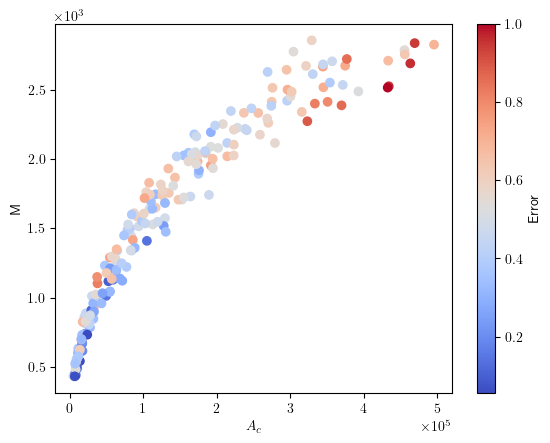

In [286]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_kb[y_test_class==1])
col1 = np.abs(y_test_kb[y_test_class==0] - y_predict_lr_bound)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-bound-error-predictwithoutclass.eps',format='eps',dpi=300)
plt.show()

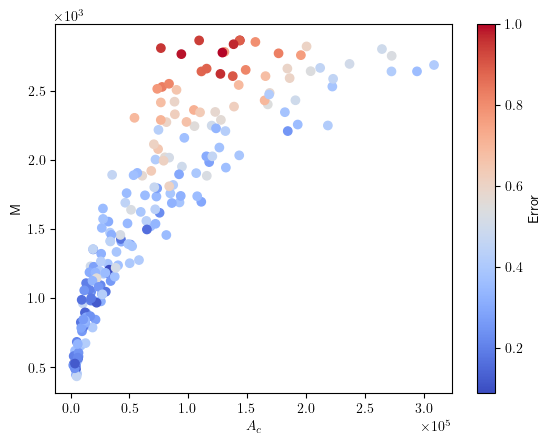

In [287]:
fig = plt.figure()
X_test_heatmap_b = pd.DataFrame(X_test_kb[y_test_class==0])
col1 = np.abs(y_test_kb[y_test_class==1] - y_predict_lr_kernel)
col1 = col1/col1.max()
sc = plt.scatter(X_test_heatmap_b.get(4), X_test_heatmap_b.get(5), c=col1, cmap='coolwarm')
xtex = r"$A_c$"
ytext = r"M"
ctex = r"Error"
plt.xlabel(xlabel=xtex)
plt.ylabel(ylabel=ytext)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.colorbar(sc, label=ctex)
plt.savefig('./figures/heatmap-kernel-error-predictwithoutclass.eps',format='eps',dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


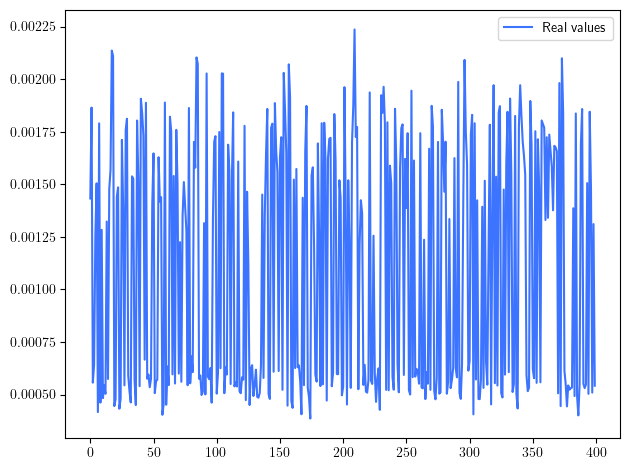

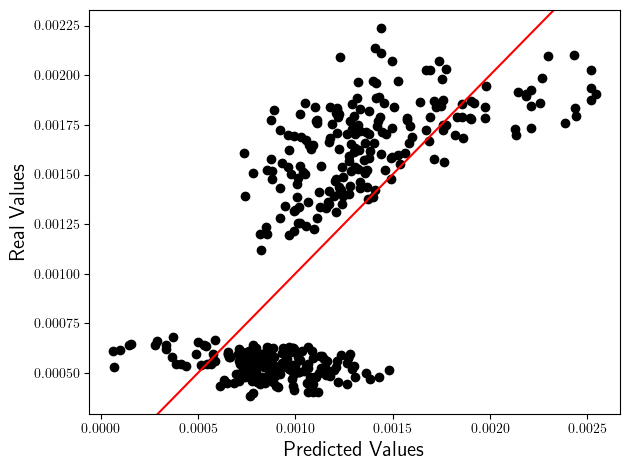

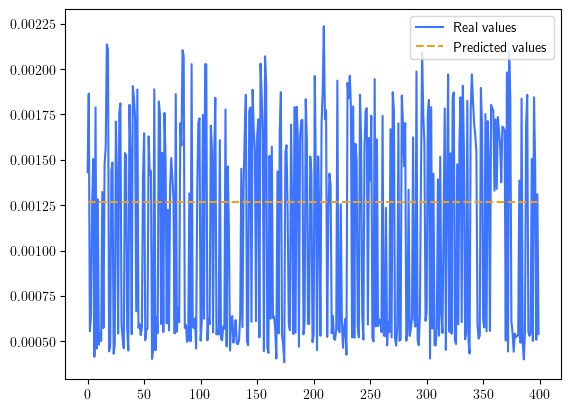

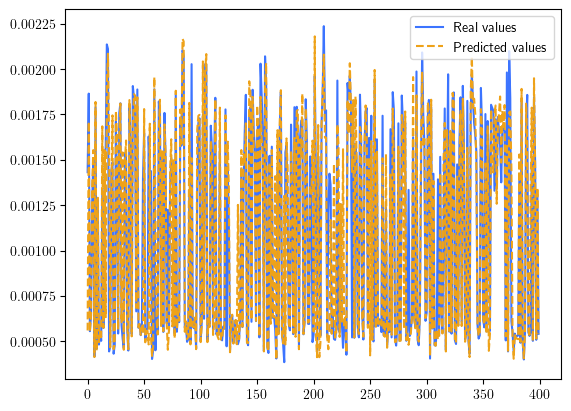

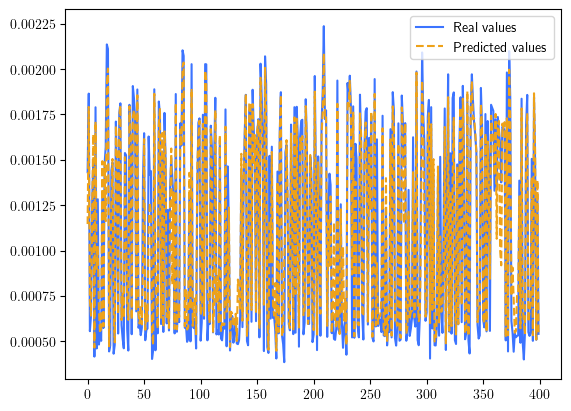

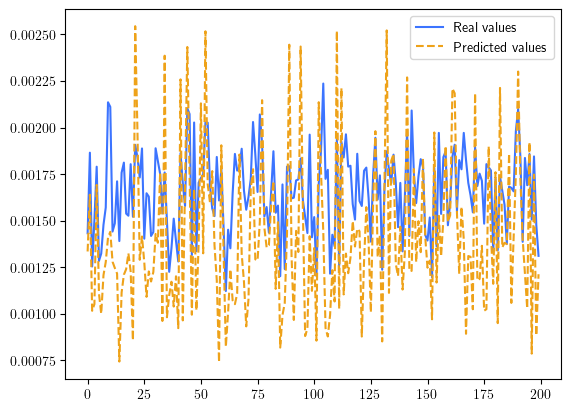

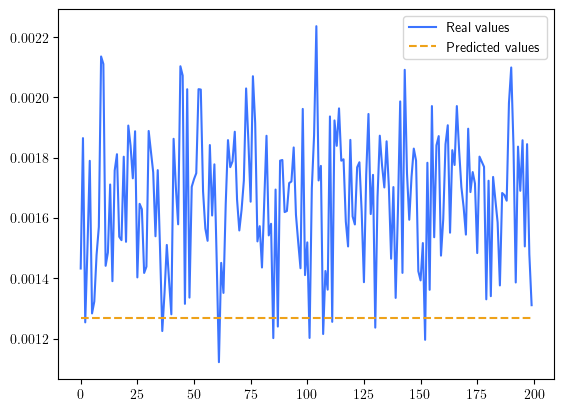

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


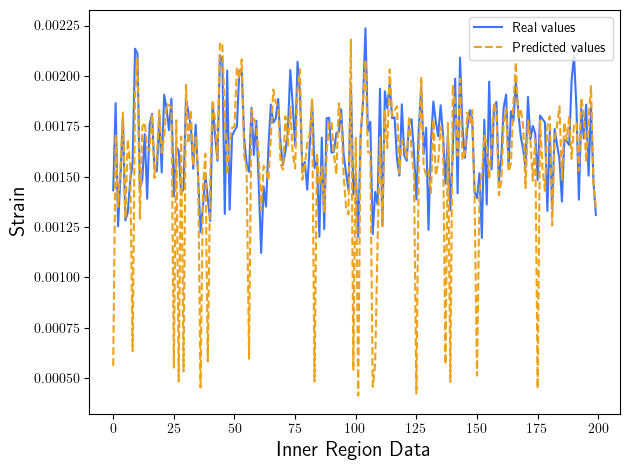

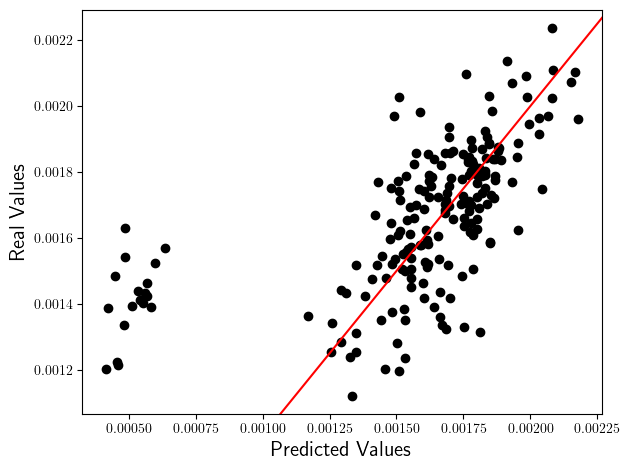

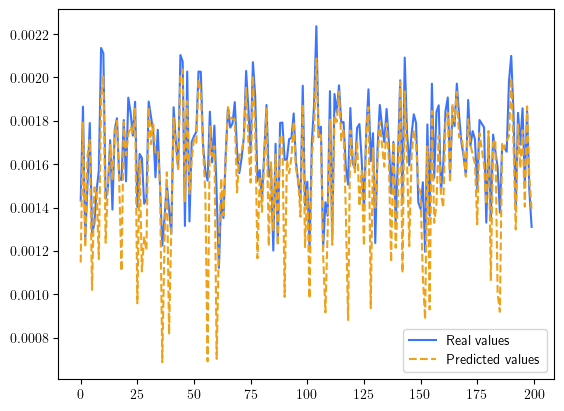

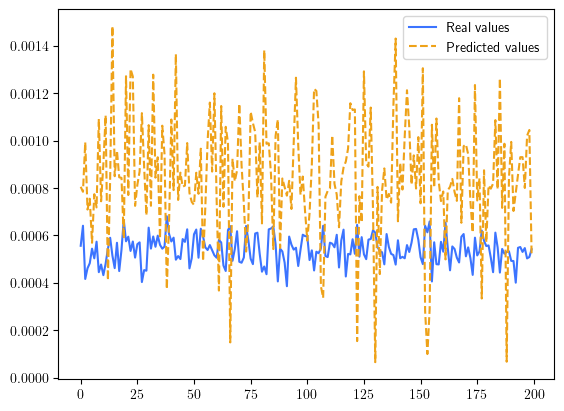

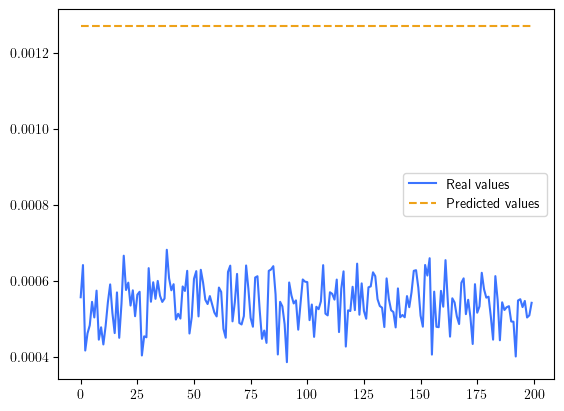

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


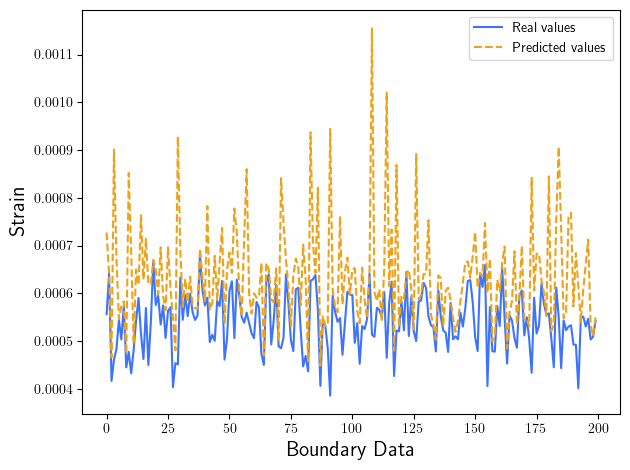

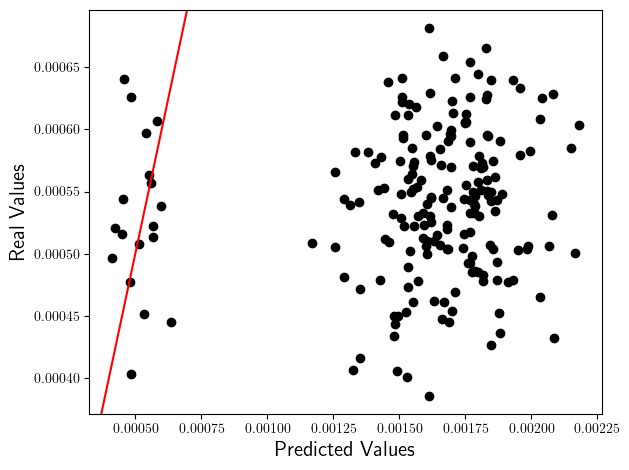

In [288]:
x=np.arange(0,len(y_test_kb),1)

fig1_kb = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/withoutclass-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/withoutclass-regression.svg')
plt.show()

fig_true_predict_kb, ax = plt.subplots()
plt.plot(y_predict_lr_kb, y_test_kb, 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/withoutclass-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

fig2 = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_svr_kb, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig3 = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_dt_kb, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4 = plt.figure()
plt.plot(x,y_test_kb, '-', color=pretty_blue, label='Real values')
plt.plot(x,y_predict_rf_kb, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

x2 = np.arange(0,len(y_test_kb[y_test_class==0]),1)

fig1k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_lr_kernel, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig2k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_svr_kernel, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig3k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_dt_kernel, '--', color=nice_orange, label='Predicted values')
plt.xlabel('Inner Region Data', fontsize=15)
plt.ylabel('Strain', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/kernel-withoutclass-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/kernel-withoutclass-regression.svg')
plt.show()

fig_true_predict_kb, ax = plt.subplots()
plt.plot(y_predict_dt_kernel, y_test_kb[y_test_class==0], 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/kernel-withoutclass-regression-true-predict.eps',format='eps',dpi=300)
plt.show()

fig4k = plt.figure()
plt.plot(x2,y_test_kb[y_test_class==0], '-', color=pretty_blue, label='Real values')
plt.plot(x2,y_predict_rf_kernel, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

x3 = np.arange(0,len(y_test_kb[y_test_class==1]),1)

fig1b = plt.figure()
plt.plot(x3,y_test_kb[y_test_class==1], '-', color=pretty_blue, label='Real values')
plt.plot(x3,y_predict_lr_bound, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig2b = plt.figure()
plt.plot(x3,y_test_kb[y_test_class==1], '-', color=pretty_blue, label='Real values')
plt.plot(x3,y_predict_svr_bound, '--', color=nice_orange, label='Predicted values')
plt.legend()
plt.show()

fig4b = plt.figure()
plt.plot(x3,y_test_kb[y_test_class==1], '-', color=pretty_blue, label='Real values')
plt.plot(x3,y_predict_rf_bound, '--', color=nice_orange, label='Predicted values')
plt.xlabel('Boundary Data', fontsize=15)
plt.ylabel('Strain', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/bound-withoutclass-regression.eps',format='eps',dpi=300)
plt.savefig('./figures/bound-withoutclass-regression.svg')
plt.show()

fig_true_predict_kb, ax = plt.subplots()
plt.plot(y_predict_dt_kernel, y_test_kb[y_test_class==1], 'ok')
lim_x = ax.get_xlim()
lim_y = ax.get_ylim()
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, '-r')
ax.set_xlim(lim_x)
ax.set_ylim(lim_y)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Real Values', fontsize=15)
plt.tight_layout()
plt.savefig('./figures/bound-withoutclass-regression-true-predict.eps',format='eps',dpi=300)
plt.show()